# Install Dataset

In [2]:
!pip install opendatasets

In [4]:
import opendatasets as op
op.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  ashleshkhajbage


Your Kaggle Key:

  ································


100%|██████████| 778M/778M [00:05<00:00, 144MB/s]  


# Import Packages

In [5]:
import os
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import cv2
import xgboost as xgb
import pathlib

In [6]:

dataset_folder = os.path.join("covid19-radiography-database/COVID-19_Radiography_Dataset/Normal")

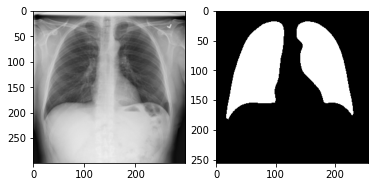

In [7]:
dataset = pathlib.Path(dataset_folder)
images_dataset = list(dataset.glob("images/*.*"))[:5000]
masks_dataset = list(dataset.glob("masks/*.*"))[:5000]
l = [images_dataset[4], masks_dataset[4]]
for i in range(2):
  plt.subplot(1, 2, i + 1)
  img  = cv2.imread(str(l[i]))
  plt.imshow(img)
plt.show()

# Preprocessing Dataset

In [8]:
def change_image_values(img):
  for i in range(48):
    for j in range(48):
      if img[i, j] <= 150:
        img[i, j] = 0
      elif img[i, j] > 150:
        img[i, j] = 1
  return img

In [9]:
images = []
for i in images_dataset:
  img = cv2.imread(str(i))
  img = cv2.resize(img, (48, 48))
  images.append(img)
images = np.asarray(images) 
images.shape

(5000, 48, 48, 3)

In [10]:
masks = []
for i in masks_dataset:
  img = cv2.imread(str(i), 0)
  img = cv2.resize(img.astype('uint8'), (48, 48), cv2.INTER_NEAREST)
  img = change_image_values(img)
  masks.append(img)
masks = np.array(masks) 
masks.shape

(5000, 48, 48)

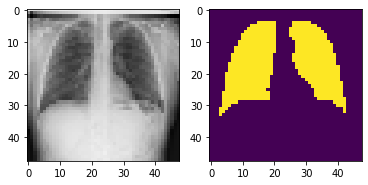

In [11]:
l = [images[4], masks[4]]
for i in range(2):
  plt.subplot(1, 2, i + 1)
  plt.imshow(l[i])
plt.show()

In [23]:
np.unique(masks[4])

array([0, 1], dtype=uint8)

# Get Features from Pre-trained VGG19 Model

In [24]:
model = tf.keras.applications.vgg19.VGG19(weights = "imagenet", include_top = False, 
                                          input_shape = (48, 48 , 3))
for i in model.layers:
  i.trainable = False

In [25]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [26]:
new_model = tf.keras.models.Model(
    model.input, 
    model.get_layer("block1_conv2").output
)
new_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
Total params: 38,720
Trainable params: 0
Non-trainable params: 38,720
_________________________________________________________________


In [27]:
features_images = new_model.predict(images, batch_size = 8)
features_images.shape

(5000, 48, 48, 64)

In [28]:
features_images[0,:,:,1].shape

(48, 48)

# plotting New-Feature

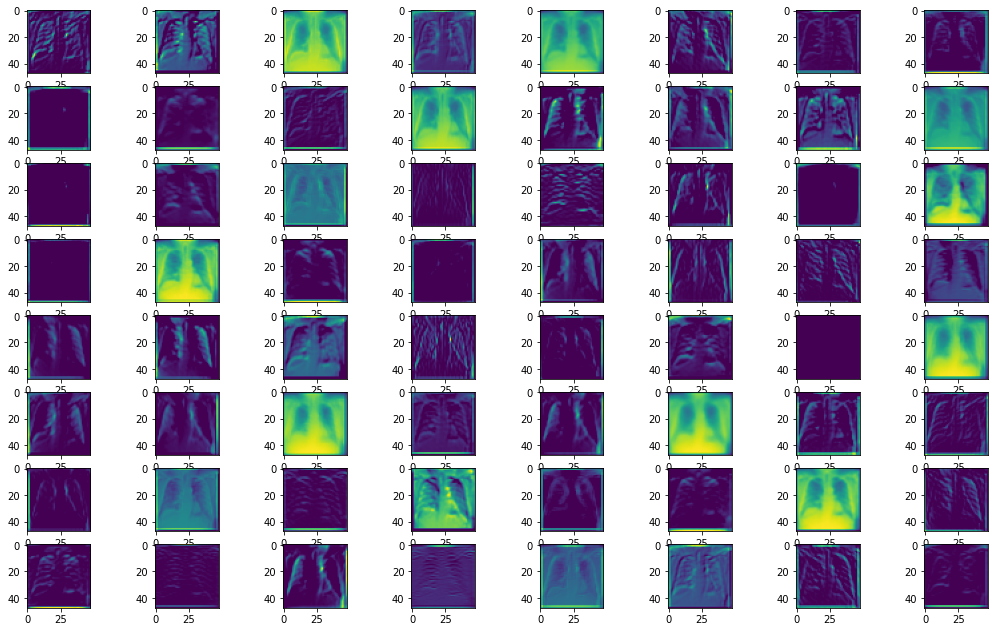

In [29]:
plt.figure(figsize = (18, 11))
counter = 1
for i in range(64):
  if counter == 65:
    break
  plt.subplot(8, 8, i + 1)
  plt.imshow(features_images[1,:,:,i])
  counter +=1
plt.show()

In [30]:
x = features_images
x = x.reshape(-1, x.shape[3])
x.shape

(11520000, 64)

In [31]:
import pandas as pd
dataset = pd.DataFrame(x)
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.000000,0.0,1.485643,0.365480,2.615800,0.0,0.292527,0.405262,0.0,1.219201,...,2.009344,1.023975,1.174392,0.328351,0.000000,0.842158,1.388447,0.309062,0.499693,1.463446
1,0.045177,0.0,2.245023,0.750136,3.849706,0.0,0.000000,0.539801,0.0,1.745007,...,3.243883,1.759799,2.364945,0.360531,0.038551,1.248868,2.006459,0.820738,0.758565,1.950199
2,0.045177,0.0,2.245023,0.750136,3.849706,0.0,0.000000,0.539801,0.0,1.745007,...,3.243883,1.759799,2.364945,0.360531,0.038551,1.248868,2.006459,0.820738,0.758565,1.950199
3,0.045177,0.0,2.245023,0.750136,3.849706,0.0,0.000000,0.539801,0.0,1.745007,...,3.243883,1.759799,2.364945,0.360531,0.038551,1.248868,2.006459,0.820738,0.758565,1.950199
4,0.045177,0.0,2.245023,0.750136,3.849706,0.0,0.000000,0.539801,0.0,1.745007,...,3.243883,1.759799,2.364945,0.360531,0.038551,1.248868,2.006459,0.820738,0.758565,1.950199


In [32]:
y = masks
y = y.reshape(y.shape[0]*y.shape[1]*y.shape[2])
y.shape

(11520000,)

In [33]:
dataset['target'] = y
dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,target
0,0.000000,0.0,1.485643,0.365480,2.615800,0.0,0.292527,0.405262,0.0,1.219201,...,1.023975,1.174392,0.328351,0.000000,0.842158,1.388447,0.309062,0.499693,1.463446,0
1,0.045177,0.0,2.245023,0.750136,3.849706,0.0,0.000000,0.539801,0.0,1.745007,...,1.759799,2.364945,0.360531,0.038551,1.248868,2.006459,0.820738,0.758565,1.950199,0
2,0.045177,0.0,2.245023,0.750136,3.849706,0.0,0.000000,0.539801,0.0,1.745007,...,1.759799,2.364945,0.360531,0.038551,1.248868,2.006459,0.820738,0.758565,1.950199,0
3,0.045177,0.0,2.245023,0.750136,3.849706,0.0,0.000000,0.539801,0.0,1.745007,...,1.759799,2.364945,0.360531,0.038551,1.248868,2.006459,0.820738,0.758565,1.950199,0
4,0.045177,0.0,2.245023,0.750136,3.849706,0.0,0.000000,0.539801,0.0,1.745007,...,1.759799,2.364945,0.360531,0.038551,1.248868,2.006459,0.820738,0.758565,1.950199,0


In [34]:
features = dataset.drop(['target'], axis = 1)
target = dataset['target']

In [35]:
features.shape

(11520000, 64)

In [36]:
norm = tf.keras.layers.Normalization(input_shape = (64, ), axis = -1)
norm.adapt(features)

In [37]:
label = tf.keras.utils.to_categorical(target)

In [38]:
m = tf.keras.models.Sequential([
    norm,
    tf.keras.layers.Dense(512, activation = "tanh"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2, activation = "softmax")
])
m.compile(loss = "binary_crossentropy", optimizer="adam", metrics=['accuracy'])
m.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 64)                129       
_________________________________________________________________
dense (Dense)                (None, 512)               33280     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 34,435
Trainable params: 34,306
Non-trainable params: 129
_________________________________________________________________


In [39]:
h = m.fit(features, label, epochs = 120, validation_split = 0.2, batch_size = 1024)

Epoch 1/120
9000/9000 [==============================] - 95s 10ms/step - loss: 0.1947 - accuracy: 0.9205 - val_loss: 0.1604 - val_accuracy: 0.9355
Epoch 2/120
9000/9000 [==============================] - 93s 10ms/step - loss: 0.1696 - accuracy: 0.9311 - val_loss: 0.1505 - val_accuracy: 0.9394
Epoch 3/120
9000/9000 [==============================] - 94s 10ms/step - loss: 0.1618 - accuracy: 0.9344 - val_loss: 0.1441 - val_accuracy: 0.9425
Epoch 4/120
9000/9000 [==============================] - 98s 11ms/step - loss: 0.1572 - accuracy: 0.9364 - val_loss: 0.1406 - val_accuracy: 0.9438
Epoch 5/120
9000/9000 [==============================] - 97s 11ms/step - loss: 0.1541 - accuracy: 0.9377 - val_loss: 0.1383 - val_accuracy: 0.9448
Epoch 6/120
9000/9000 [==============================] - 96s 11ms/step - loss: 0.1517 - accuracy: 0.9388 - val_loss: 0.1364 - val_accuracy: 0.9456
Epoch 7/120
9000/9000 [==============================] - 96s 11ms/step - loss: 0.1500 - accuracy: 0.9395 - val_loss: 0

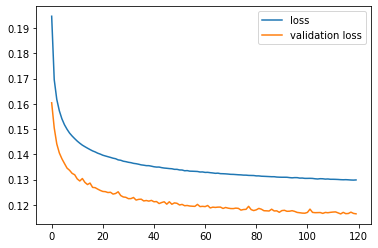

In [40]:
plt.plot(h.history['loss'], label = "loss")
plt.plot(h.history['val_loss'], label = "validation loss")
plt.legend()

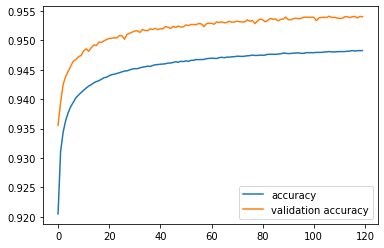

In [41]:
plt.plot(h.history['accuracy'], label = "accuracy")
plt.plot(h.history['val_accuracy'], label = "validation accuracy")
plt.legend()

In [42]:
m.evaluate(features, label)

360000/360000 [==============================] - 700s 2ms/step - loss: 0.1159 - accuracy: 0.9541


[0.1158776506781578, 0.9541158080101013]

# Test Model

In [43]:
def image_segmentation(img):
  img = np.reshape(img, (1, 48, 48, 3))
  features_img = new_model.predict(img)
  features_img = np.array(features_img)
  features_img = features_img.reshape(-1, features_img.shape[3])
  y_pred = m.predict(features_img)
  y_pred = np.array(y_pred)
  y_pred = np.argmax(y_pred, axis = 1)
  y_pred = y_pred.reshape(48, 48)
  return y_pred

In [44]:
def test_image(ind):
  img = images[ind]
  y_pred = image_segmentation(img)
  mask = masks[ind]
  list_fig = [img, mask, y_pred]
  list_title = ["orginal image", "orginal mask", "My Model"]
  plt.figure(figsize = (6, 8))
  for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.imshow(list_fig[i])
    plt.title(list_title[i])
  plt.show()

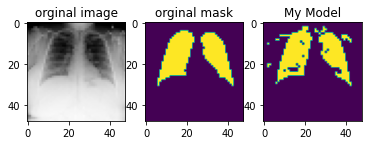

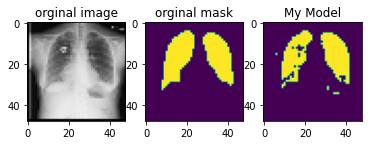

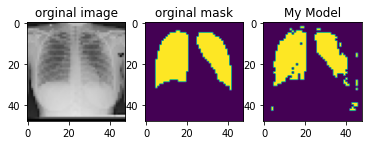

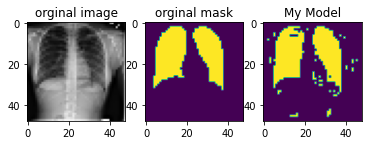

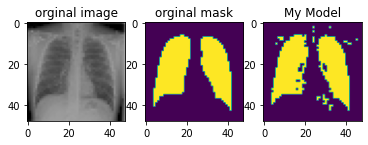

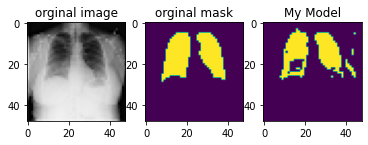

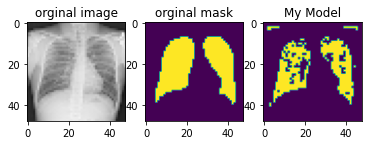

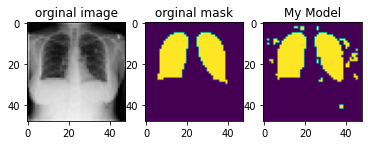

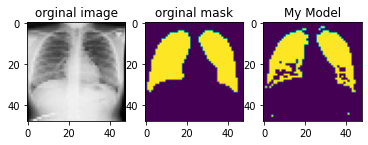

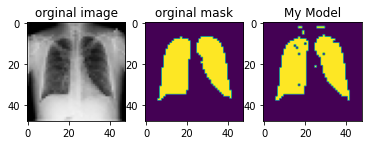

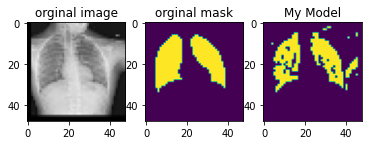

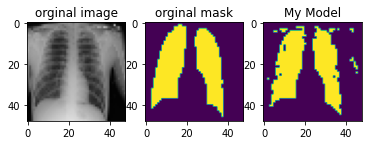

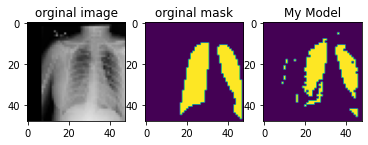

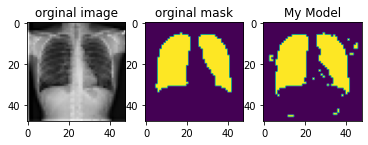

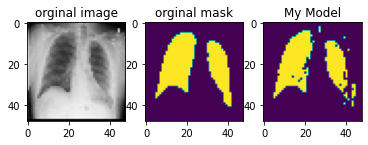

In [45]:
for i in range(30, 45):
  test_image(i)